# Preventive Medical Screening in Unborn

## First week

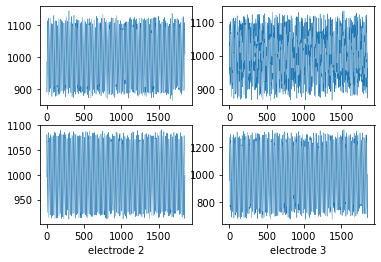

In [2]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

mat = scipy.io.loadmat('heartbeat_data/005.mat')

y=mat['val'][0]
electrode0=y[0]
electrode1=y[1]
electrode2=y[2]
electrode3=y[3]

fig,ax = plt.subplots(2,2)
x=(np.arange(0,len(electrode0)))

ax[0][0].plot(x,electrode0,linewidth=.4)
ax[0][1].plot(x,electrode1,linewidth=.4)
ax[1][0].plot(x,electrode2,linewidth=.4)
ax[1][1].plot(x,electrode3,linewidth=.4)
ax[0][0].set_xlabel('electrode 0')
ax[0][1].set_xlabel('electrode 1')
ax[1][0].set_xlabel('electrode 2')
ax[1][1].set_xlabel('electrode 3')

plt.show()

In [3]:
from sklearn.decomposition import FastICA


transformer = FastICA()
y_transposed = y.T
y_transformed = transformer.fit_transform(y_transposed)

print(y_transformed)

[[-0.02525196 -0.0354817   0.00511375 -0.04010997]
 [-0.02462156 -0.03563273  0.0156096  -0.01562836]
 [-0.0221598  -0.03500009  0.0278964  -0.03111493]
 ...
 [ 0.01172713  0.0167046  -0.02417569  0.01332337]
 [ 0.01276182  0.01574148 -0.01127651 -0.03977058]
 [ 0.01018806  0.01391374 -0.00293261  0.01054436]]


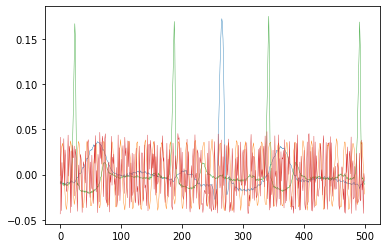

In [6]:
import os
directory = 'heartbeat_data'

stop=1  #set the number of files you want to go through
count=0

for filename in os.listdir(directory):
  count+=1
  mat = scipy.io.loadmat('heartbeat_data/'+filename)

  y=mat['val'][0]
  transformer = FastICA()
  y_transposed = y.T
  y_transformed = transformer.fit_transform(y_transposed)
  N=500

  x2=(np.arange(0,N))

  signal1=np.array([y_transformed[i][0] for i in range(N)])
  signal2=np.array([y_transformed[i][1] for i in range(N)])
  signal3=np.array([y_transformed[i][2] for i in range(N)])
  signal4=np.array([y_transformed[i][3] for i in range(N)])

  plt.plot(x2,signal1,linewidth=.4)
  plt.plot(x2,signal2,linewidth=.4)
  plt.plot(x2,signal3,linewidth=.4)
  plt.plot(x2,signal4,linewidth=.4)
  plt.show()
  if count==stop:
    break



In [ ]:
# Plotting data
# create 100 equally spaced points between -3 and 3
x_linspace = np.linspace(0, len(y_transformed), len(y_transformed))

#print(x_linspace.size)

fig_subset_view, ax_subset_view = plt.subplots()
ax_subset_view.grid()
ax_subset_view.set_ylim([-1, 1])
ax_subset_view.set_xlim([0,1500])
ax_subset_view.plot(x_linspace, y_transformed)

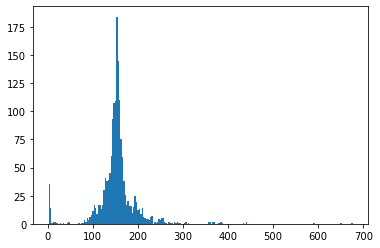

83.5 221.5


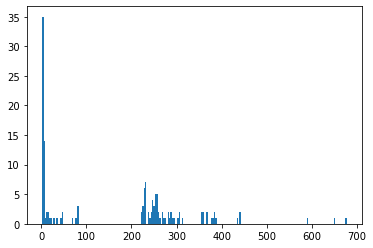

In [40]:
import scipy.io
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy.stats as st
from sklearn.decomposition import FastICA

def load_data(file):
    mat = scipy.io.loadmat(file)
    return mat['val'][0]

def show_single_plot(y_beat, spike_times, spike_vals):
    fig_subset_view, ax = plt.subplots()
    ax.scatter(spike_times, spike_vals, color='red')
    ax.grid()
    show_multiplot(ax, y_beat)

def show_multiplot(ax, y):
    x_linspace = np.linspace(0, len(y), len(y))
    ax.set_xlim([0, len(y)])
    ax.plot(x_linspace, y)


def apply_filter(y_transformed, strength):
    filtered_y = np.array([])
    for row in y_transformed.T:
        
        filtered_row = savgol_filter(row, strength, 1)
        filtered_row = filtered_row.T
        filtered_y = np.append(filtered_y, filtered_row)
        filtered_y = np.reshape(filtered_y, (-1, 1500))
    return filtered_y.T

def filter_noise(filename):
    mat = scipy.io.loadmat('heartbeat_data/'+filename)
    y=mat['val'][0]
    y_transposed = y.T # columns
    transformer = FastICA(whiten='unit-variance')
    y_transformed = transformer.fit_transform(y_transposed)
    y_beats = []

    for row in y_transformed.T:
        if min(row)< -0.055 or max(row)>0.055:
            # flip sign
            if abs(np.min(row)) > abs(np.max(row)):
                row = row * -1
            y_beats.append(row)

    y_beats = np.asarray(y_beats)
    # fig_subset_view, ax = plt.subplots()
    # ax.grid()
    # show_multiplot(ax, y_beats.T)
    return y_beats


def filter_fetus(y_beats):
    sum_first_beats = sum(scipy.signal.find_peaks(y_beats[0], height=0.055)[0])
    sum_second_beats = sum(scipy.signal.find_peaks(y_beats[1], height=0.055)[0])
    return  y_beats[0] if sum_first_beats > sum_second_beats else y_beats[1]

def better_anomalies_detection(data, cofidence):
    interval = st.t.interval(confidence= cofidence, df=len(data)-1,
              loc=np.mean(data),
              scale=st.sem(data))
    print(interval)
    #dists[(np.where((dists >= r) & (dists <= r + dr)))]
    outliers = []
    for point in data:
        if point < interval[0] or point > interval[1]:
            outliers.append(point)
    return outliers

def find_anomalies(data):
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    print(data_mean)
    cuttoff=1 # 68% -1 , 95% -2 , 99.7% -3
    anomaly_cut_off = data_std * cuttoff
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    
    return anomalies

def anomalies_detection(data, confidence):
    interval = st.t.interval(alpha= confidence, df=len(data)-1,loc=np.mean(data),scale=st.sem(data))
    print(interval)
    outliers = []
    for point in data:
        if point < interval[0] or point > interval[1]:
            outliers.append(point)
    return outliers

def calc_interquantile_range(data_distribution):
    quantiles = np.quantile(data_distribution, [0,0.25,0.5,0.75,1])
    interQuartileRange=quantiles[3]-quantiles[1]
    

def main():
    start = 0
    stop = 153  #set the number of files you want to go through
    peak_widths=[]
    for i, filename in enumerate(os.listdir('heartbeat_data')):
        out = re.findall(r'\d+', filename)
        if int(out[0]) < start:
            continue
        if i == stop:
            break
        y_beats = filter_noise(filename)
        y_beat = filter_fetus(y_beats)
        
        peaks = scipy.signal.find_peaks(y_beat, height=0.055)
        spike_times= peaks[0]
        spike_vals = peaks[1]['peak_heights']

        


        # collect this

        peak_widtha_diff=[np.abs(spike_times[i]-spike_times[i+1]) for i in range(len(spike_times)-1)]
        peak_widths=np.concatenate((peak_widths,peak_width_diff),axis=None)
    plt.hist(peak_widths,bins=len(np.unique(peak_widths)))
    plt.show()

    #x = np.quantile(peak_widths, [0,0.25,0.5,0.75,1])
    #interQuartileRange=x[3]-x[1]


    
    upperLimit=x[3]+2.5*interQuartileRange
    lowerLimit=x[1]-2.5*interQuartileRange
    print(lowerLimit,upperLimit)
    outliers=[x for x in peak_widths if x<lowerLimit or x>upperLimit]
    plt.hist(outliers,bins=len(np.unique(peak_widths)))
    
    plt.show()
        
main()